<a href="https://colab.research.google.com/github/bhojaram/Flipkart-Data-Analysis/blob/main/Data_Engineering_Bhojaram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary drivers/requirements

In [ ]:
!pip install selenium webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 34.6 MB/s eta 0:00:00


In [ ]:
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb

--2025-05-25 11:39:18--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 173.194.195.91, 173.194.195.136, 173.194.195.93, ...
Connecting to dl.google.com (dl.google.com)|173.194.195.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116499092 (111M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb.1’

google-chrome-stabl 100%[===================>] 111.10M   281MB/s    in 0.4s    

2025-05-25 11:39:18 (281 MB/s) - ‘google-chrome-stable_current_amd64.deb.1’ saved [116499092/116499092]



In [ ]:
!sudo apt-get install ./google-chrome-stable_current_amd64.deb -y --fix-broken

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'google-chrome-stable' instead of './google-chrome-stable_current_amd64.deb'
The following additional packages will be installed:
  libvulkan1 mesa-vulkan-drivers
The following NEW packages will be installed:
  google-chrome-stable libvulkan1 mesa-vulkan-drivers
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.9 MB/127 MB of archives.
After this operation, 433 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan1 amd64 1.3.204.1-2 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 mesa-vulkan-drivers amd64 23.2.1-1ubuntu3.1~22.04.3 [10.7 MB]
Get:3 /content/google-chrome-stable_current_amd64.deb google-chrome-stable amd64 136.0.7103.113-1 [116 MB]
Fetched 10.9 MB in 4s (3,095 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is 

# Creating **df_mobile** csv file and analysis

In [ ]:
#Importing necessary Librarires

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import tempfile
import re

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException


def get_flipkart_data_selenium(category_url, pages=1):

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
    }

    # Selenium WebDriver set up
    options = webdriver.ChromeOptions()

    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    options.add_argument(f'user-agent={headers["User-Agent"]}')


    options.add_argument('--no-first-run')
    options.add_argument('--no-default-browser-check')



    temp_dir = tempfile.mkdtemp()
    options.add_argument(f'user-data-dir={temp_dir}')
    print(f"Using temporary user data directory: {temp_dir}")


    try:

        driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
    except Exception as e:
        print(f"Error initializing WebDriver: {e}")

        if 'temp_dir' in locals() and os.path.exists(temp_dir):

             try:
                 import shutil
                 shutil.rmtree(temp_dir)
                 print(f"Cleaned up temporary directory: {temp_dir}")
             except Exception as cleanup_e:
                 print(f"Error during cleanup of {temp_dir}: {cleanup_e}")

        return pd.DataFrame()

    # creating lists to store the scraped data
    Product_name=[]
    Price =[]
    Rating=[]
    People_rated_count = []
    People_reviewed_count = []

    for page in range(1, pages + 1):
        url = f"{category_url}&page={page}"
        print(f"Attempting to retrieve page: {url}")

        try:
            driver.get(url)


            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.CLASS_NAME, 'DOjaWF'))
            )


            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # define main container
            main_container = soup.find('div', {'class': 'DOjaWF gdgoEp'})

            if main_container:

                Products = main_container.find_all("div", class_="cPHDOP col-12-12")
                if not Products:
                    print(f"No products found on page {page}.")
            else:
                Products = []
                print(f"Main container not found on page {page}.")

            for Product in Products :
                try:
                    name_element = Product.find("div",class_ ="KzDlHZ")
                    name = name_element.text.strip() if name_element else "N/A"

                    price_element = Product.find('div', {'class': 'Nx9bqj _4b5DiR'})
                    price = price_element.text.strip() if price_element else "N/A"

                    rating_element = Product.find('div', {'class': 'XQDdHH'})
                    rating = rating_element.text.strip() if rating_element else "N/A"




                    container = Product.find('span', class_='Wphh3N')
                    people_rated_count = 0
                    if container:
                       spans = container.find_all('span')
                       if spans:
                          ratings_text = spans[0].get_text()
                          try:
                              people_rated_count = int(re.search(r'([\d,]+)', ratings_text).group(1).replace(',', ''))
                          except Exception:
                              people_rated_count = 0


                    people_reviewed_count = 0
                    reviewed_element = Product.find('span', class_='hG7V+4')
                    if reviewed_element:

                       next_sibling = reviewed_element.find_next_sibling('span')
                       if next_sibling:
                          reviews_text = next_sibling.get_text()
                          try:
                              people_reviewed_count = int(re.search(r'([\d,]+)', reviews_text).group(1).replace(',', ''))
                          except Exception:
                               people_reviewed_count = 0






                    Product_name.append(name)
                    Price.append(price)
                    Rating.append(rating)

                    People_rated_count.append(people_rated_count)
                    People_reviewed_count.append(people_reviewed_count)

                except Exception as e:
                    print(f"Error processing product element on page {page}: {e}")



        except TimeoutException:
            print(f"Timeout waiting for page {page} to load. Skipping page.")
        except Exception as e:
            print(f"An error occurred while processing page {page}: {e}")



        time.sleep(7)

    driver.quit()

    # Clean up temporary  data directory
    if 'temp_dir' in locals() and os.path.exists(temp_dir):
        try:
            import shutil
            shutil.rmtree(temp_dir)
            print(f"Cleaned up temporary directory: {temp_dir}")
        except Exception as cleanup_e:
            print(f"Error during cleanup of {temp_dir}: {cleanup_e}")



    products_df = pd.DataFrame({
        'Product_name': Product_name,
        'Price': Price,
        'Rating': Rating,
        'People_rated_count': People_rated_count,
        'People_reviewed_count': People_reviewed_count

    })

    return products_df

# page url and no. of pages to scrap
category_url = "https://www.flipkart.com/search?q=mobile%20phones&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
df_mobile = get_flipkart_data_selenium(category_url, pages=20) # Use the new function name
if not df_mobile.empty:
    df_mobile.to_csv('flipkart_mobile.csv', index=False)
    print("Data successfully scraped and saved to flipkart_mobile.csv")
else:
    print("No data scraped. CSV file not created.")

Using temporary user data directory: /tmp/tmpoquol4kq
Attempting to retrieve page: https://www.flipkart.com/search?q=mobile%20phones&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=1
Attempting to retrieve page: https://www.flipkart.com/search?q=mobile%20phones&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=2
Attempting to retrieve page: https://www.flipkart.com/search?q=mobile%20phones&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=3
Attempting to retrieve page: https://www.flipkart.com/search?q=mobile%20phones&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=4
Attempting to retrieve page: https://www.flipkart.com/search?q=mobile%20phones&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=5
Attempting to retrieve page: https://www.flipkart.com/search?q=mobile%20phones&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=

In [ ]:
# Extracting memory(GB) in mobile category
import re
def extract_memory(product_name):
    match = re.search(r'\(.*,\s*(\d+\s).*?\)', product_name)
    if match:
        return match.group(1)
    return None
df_mobile['Memory_Specification'] = df_mobile['Product_name'].apply(extract_memory)

In [ ]:
df_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Product_name           520 non-null    object
 1   Price                  520 non-null    object
 2   Rating                 520 non-null    object
 3   People_rated_count     520 non-null    int64 
 4   People_reviewed_count  520 non-null    int64 
 5   Memory_Specification   442 non-null    object
dtypes: int64(2), object(4)
memory usage: 24.5+ KB


In [ ]:
# Replacing 'N/A' with 0/0.0 if intger/float
df_mobile['Price'] = df_mobile['Price'].astype(str).replace('N/A', '0').str.replace('[₹,]', '', regex=True).astype(int)
df_mobile['Rating'] = df_mobile['Rating'].astype(str).replace('N/A', '0').astype(float)
df_mobile['Memory_Specification'] = df_mobile['Memory_Specification'].astype(str).str.replace('[^0-9]', '', regex=True)
df_mobile['Memory_Specification'] = df_mobile['Memory_Specification'].replace('', '0').astype(int)

In [ ]:
df_mobile.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,Memory_Specification
0,"Motorola G85 5G (Cobalt Blue, 128 GB)",15999,4.4,185557,9717,128
1,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4.5,169648,6066,128
2,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4.5,169648,6066,128
3,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4.5,169648,6066,128
4,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,15999,4.4,20194,895,256


In [ ]:
# Creating a new column 'category'
df_mobile['category'] = 'mobile_phones'

In [ ]:
# remove 'N/A' from product_name column in df_mobile

df_mobile = df_mobile[df_mobile['Product_name'] != 'N/A']


In [ ]:
df_mobile.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,Memory_Specification,category
0,"Motorola G85 5G (Cobalt Blue, 128 GB)",15999,4.4,185557,9717,128,mobile_phones
1,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4.5,169648,6066,128,mobile_phones
2,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4.5,169648,6066,128,mobile_phones
3,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4.5,169648,6066,128,mobile_phones
4,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,15999,4.4,20194,895,256,mobile_phones


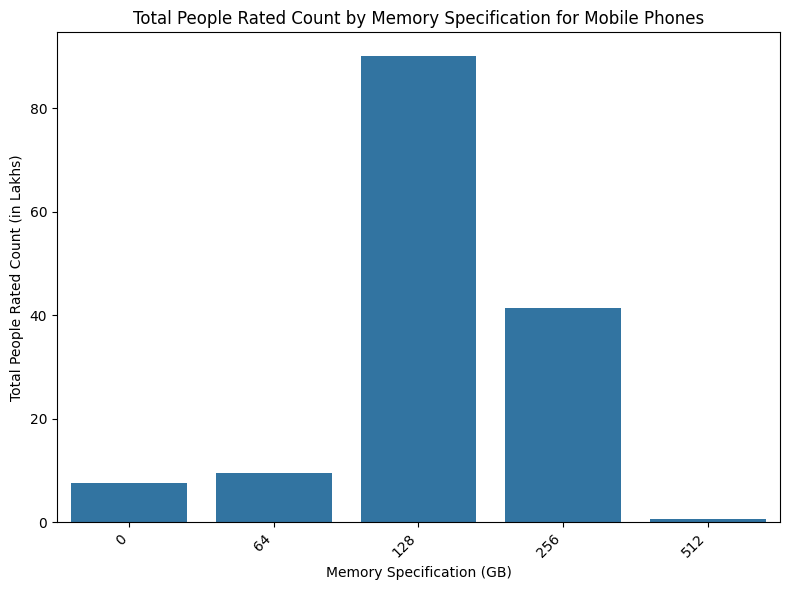

In [ ]:



import matplotlib.pyplot as plt
import seaborn as sns

# Group by Memory Specification and sum the People_rated_count
memory_rating_counts = df_mobile.groupby('Memory_Specification')['People_rated_count'].sum().reset_index()

# Convert People_rated_count to lakhs (divide by 100000)
memory_rating_counts['People_rated_count_lakhs'] = memory_rating_counts['People_rated_count'] / 100000

# Sort by the sum of people rated count for better visualization
memory_rating_counts = memory_rating_counts.sort_values(by='People_rated_count_lakhs', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Memory_Specification', y='People_rated_count_lakhs', data=memory_rating_counts)
plt.xlabel('Memory Specification (GB)')
plt.ylabel('Total People Rated Count (in Lakhs)')
plt.title('Total People Rated Count by Memory Specification for Mobile Phones')
plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


#**Memory specification of 128 GB is on demand**

<ipython-input-15-6d4b0f19c1f5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_products['People_rated_count_lakhs'] = top_products['People_rated_count'] / 100000
<ipython-input-15-6d4b0f19c1f5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='People_rated_count_lakhs', y='Product_name', data=top_products, palette='viridis')


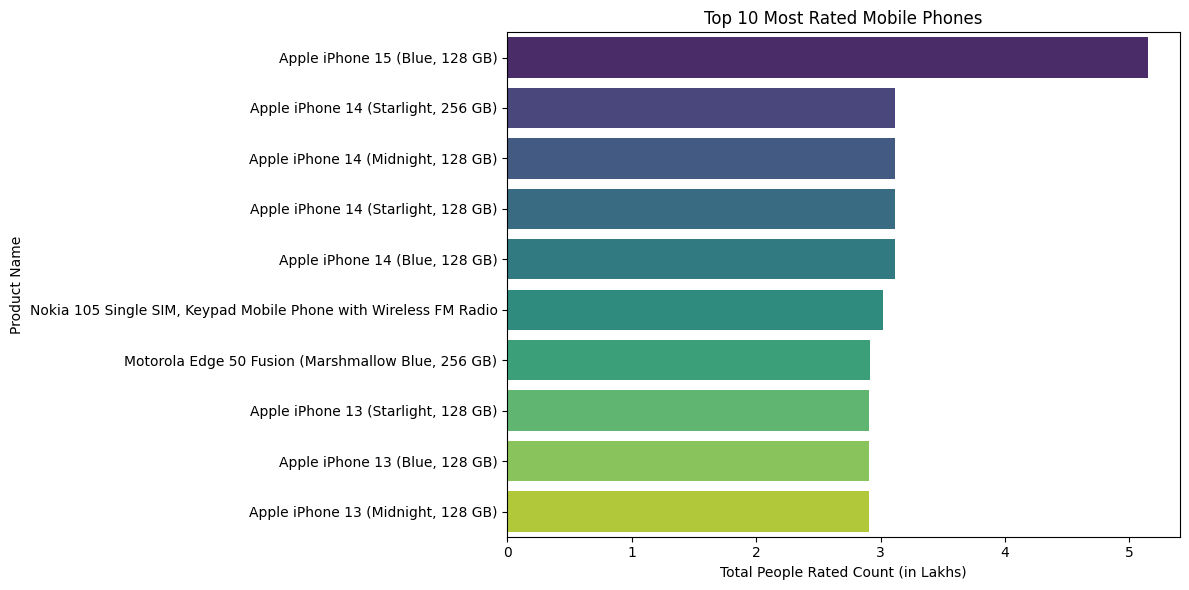

In [ ]:


# Group by product name and sum the number of people rated
product_sales = df_mobile.groupby('Product_name')['People_rated_count'].sum().reset_index()

# Sort by the total people rated count in descending order
product_sales = product_sales.sort_values(by='People_rated_count', ascending=False)

# Select the top N products for better visualization (e.g., top 10)
top_n = 10
top_products = product_sales.head(top_n)

# Convert People_rated_count to lakhs for the plot
top_products['People_rated_count_lakhs'] = top_products['People_rated_count'] / 100000

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='People_rated_count_lakhs', y='Product_name', data=top_products, palette='viridis')
plt.xlabel('Total People Rated Count (in Lakhs)')
plt.ylabel('Product Name')
plt.title(f'Top {top_n} Most Rated Mobile Phones')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Creating **df_tv** csv file and analysis

In [ ]:
#Importing necessary Librarires

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import tempfile
import re

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException


def get_flipkart_data_selenium(category_url, pages=1):

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
    }

    # Selenium WebDriver set up
    options = webdriver.ChromeOptions()

    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    options.add_argument(f'user-agent={headers["User-Agent"]}')


    options.add_argument('--no-first-run')
    options.add_argument('--no-default-browser-check')



    temp_dir = tempfile.mkdtemp()
    options.add_argument(f'user-data-dir={temp_dir}')
    print(f"Using temporary user data directory: {temp_dir}")


    try:

        driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
    except Exception as e:
        print(f"Error initializing WebDriver: {e}")

        if 'temp_dir' in locals() and os.path.exists(temp_dir):

             try:
                 import shutil
                 shutil.rmtree(temp_dir)
                 print(f"Cleaned up temporary directory: {temp_dir}")
             except Exception as cleanup_e:
                 print(f"Error during cleanup of {temp_dir}: {cleanup_e}")

        return pd.DataFrame()


    Product_name=[]
    Price =[]
    Rating=[]
    People_rated_count = []
    People_reviewed_count = []

    for page in range(1, pages + 1):
        url = f"{category_url}&page={page}"
        print(f"Attempting to retrieve page: {url}")

        try:
            driver.get(url)


            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.CLASS_NAME, 'DOjaWF'))
            )


            soup = BeautifulSoup(driver.page_source, 'html.parser')

            main_container = soup.find('div', {'class': 'DOjaWF YJG4Cf'})

            if main_container:

                Products = main_container.find_all("div", class_="cPHDOP col-12-12")
                if not Products:
                    print(f"No products found on page {page}.")
            else:
                Products = []
                print(f"Main container not found on page {page}.")

            for Product in Products :
                try:
                    name_element = Product.find("div",class_ ="KzDlHZ")
                    name = name_element.text.strip() if name_element else "N/A"

                    price_element = Product.find('div', {'class': 'Nx9bqj _4b5DiR'})
                    price = price_element.text.strip() if price_element else "N/A"

                    rating_element = Product.find('div', {'class': 'XQDdHH'})
                    rating = rating_element.text.strip() if rating_element else "N/A"




                    container = Product.find('span', class_='Wphh3N')
                    people_rated_count = 0
                    if container:
                       spans = container.find_all('span')
                       if spans:
                          ratings_text = spans[0].get_text()
                          try:
                              people_rated_count = int(re.search(r'([\d,]+)', ratings_text).group(1).replace(',', ''))
                          except Exception:
                              people_rated_count = 0


                    people_reviewed_count = 0
                    reviewed_element = Product.find('span', class_='hG7V+4')
                    if reviewed_element:

                       next_sibling = reviewed_element.find_next_sibling('span')
                       if next_sibling:
                          reviews_text = next_sibling.get_text()
                          try:
                              people_reviewed_count = int(re.search(r'([\d,]+)', reviews_text).group(1).replace(',', ''))
                          except Exception:
                               people_reviewed_count = 0






                    Product_name.append(name)
                    Price.append(price)
                    Rating.append(rating)

                    People_rated_count.append(people_rated_count)
                    People_reviewed_count.append(people_reviewed_count)

                except Exception as e:
                    print(f"Error processing product element on page {page}: {e}")



        except TimeoutException:
            print(f"Timeout waiting for page {page} to load. Skipping page.")
        except Exception as e:
            print(f"An error occurred while processing page {page}: {e}")



        time.sleep(7)

    driver.quit()

    # Clean up temporary  data directory
    if 'temp_dir' in locals() and os.path.exists(temp_dir):
        try:
            import shutil
            shutil.rmtree(temp_dir)
            print(f"Cleaned up temporary directory: {temp_dir}")
        except Exception as cleanup_e:
            print(f"Error during cleanup of {temp_dir}: {cleanup_e}")



    products_df = pd.DataFrame({
        'Product_name': Product_name,
        'Price': Price,
        'Rating': Rating,
        'People_rated_count': People_rated_count,
        'People_reviewed_count': People_reviewed_count

    })

    return products_df


category_url = "https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
df_tv = get_flipkart_data_selenium(category_url, pages=20) # Use the new function name
if not df_tv.empty:
    df_tv.to_csv('flipkart_tv.csv', index=False)
    print("Data successfully scraped and saved to flipkart_tv.csv")
else:
    print("No data scraped. CSV file not created.")

Using temporary user data directory: /tmp/tmpliqc7sw6
Attempting to retrieve page: https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=1
Attempting to retrieve page: https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=2
Attempting to retrieve page: https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=3
Attempting to retrieve page: https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=4
Attempting to retrieve page: https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=5
Attempting to retrieve page: https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=6
Attempting to retrieve page: https://www.flipkart.com/search?q=tv&otracker=s

In [ ]:
df_tv.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count
0,N/A,N/A,N/A,0,0
1,N/A,N/A,N/A,0,0
2,MOTOROLA 109 cm (43 inch) QLED Full HD Smart G...,"₹18,499",4.4,70,9
3,MOTOROLA 140 cm (55 inch) QLED Ultra HD (4K) S...,"₹29,999",4.2,232,37
4,realme TechLife CineSonic Q 80 cm (32 inch) QL...,"₹9,799",4.1,4143,370


In [ ]:
# Using dataframe df_tv: if 'N/A' present in product_name then remove that row

# Remove rows where 'Product_name' contains 'N/A'
df_tv = df_tv[~df_tv['Product_name'].str.contains('N/A', na=False)]

In [ ]:
# extract tv_size

import re

# Extract numbers followed by ' inch' from 'Product_name' and store in 'tv_size'
df_tv['tv_size'] = df_tv['Product_name'].str.extract(r'(\d+)\s*inch')

In [ ]:
# Clean and convert 'tv_size' to integer

# Fill NaN values with 0 before converting to integer
df_tv['tv_size'] = df_tv['tv_size'].fillna('0').astype(str).str.replace('[^0-9]', '', regex=True)
df_tv['tv_size'] = df_tv['tv_size'].replace('', '0').astype(int)


# Ensure 'Price' is treated as string before cleaning and converting
df_tv['Price'] = df_tv['Price'].astype(str).replace('N/A', '0').str.replace('[₹,]', '', regex=True).astype(int)

# Ensure 'Rating' is treated as string before cleaning and converting
df_tv['Rating'] = df_tv['Rating'].astype(str).replace('N/A', '0').astype(float)



In [ ]:
# adding a new category
df_tv['category'] = 'appliances'

In [ ]:
df_tv.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,tv_size,category
2,MOTOROLA 109 cm (43 inch) QLED Full HD Smart G...,18499,4.4,70,9,43,appliances
3,MOTOROLA 140 cm (55 inch) QLED Ultra HD (4K) S...,29999,4.2,232,37,55,appliances
4,realme TechLife CineSonic Q 80 cm (32 inch) QL...,9799,4.1,4143,370,32,appliances
5,Infinix 80 cm (32 inch) HD Ready LED Smart Lin...,7999,4.2,55623,5628,32,appliances
6,LG UR7500 108 cm (43 inch) Ultra HD (4K) LED S...,27990,4.4,21379,1599,43,appliances


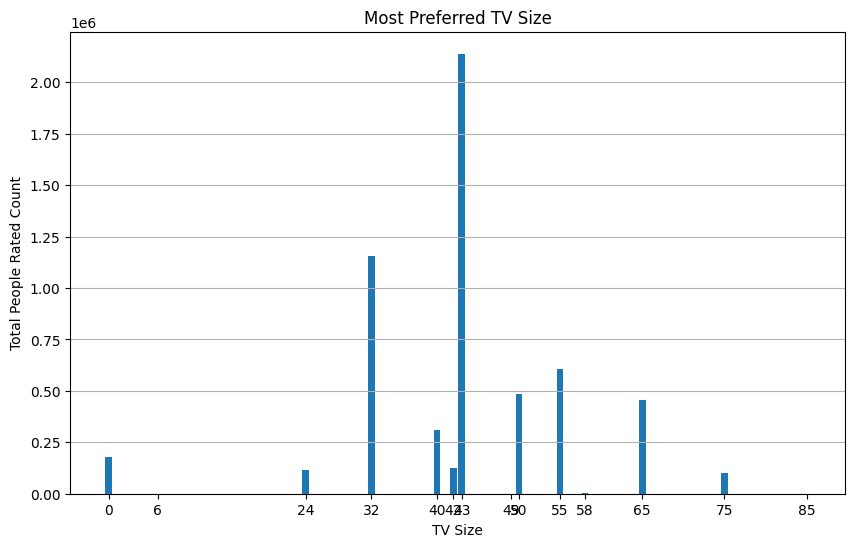

In [ ]:

import matplotlib.pyplot as plt

# Group by tv_size and sum the People_rated_count
tv_size_ratings = df_tv.groupby('tv_size')['People_rated_count'].sum().reset_index()

# Sort by People_rated_count in descending order
tv_size_ratings = tv_size_ratings.sort_values(by='People_rated_count', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(tv_size_ratings['tv_size'], tv_size_ratings['People_rated_count'])
plt.xlabel('TV Size')
plt.ylabel('Total People Rated Count')
plt.title('Most Preferred TV Size')
plt.xticks(tv_size_ratings['tv_size'])
plt.grid(axis='y')
plt.show()

# **Most prefered tv size is 32 inch followed by 43 inch**

<ipython-input-24-4fa0d64d3a9e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_selling_tv['People_rated_count_lakhs'] = top_selling_tv['People_rated_count'] / 100000
<ipython-input-24-4fa0d64d3a9e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='People_rated_count_lakhs', y='Product_name', data=top_selling_tv, palette='viridis')


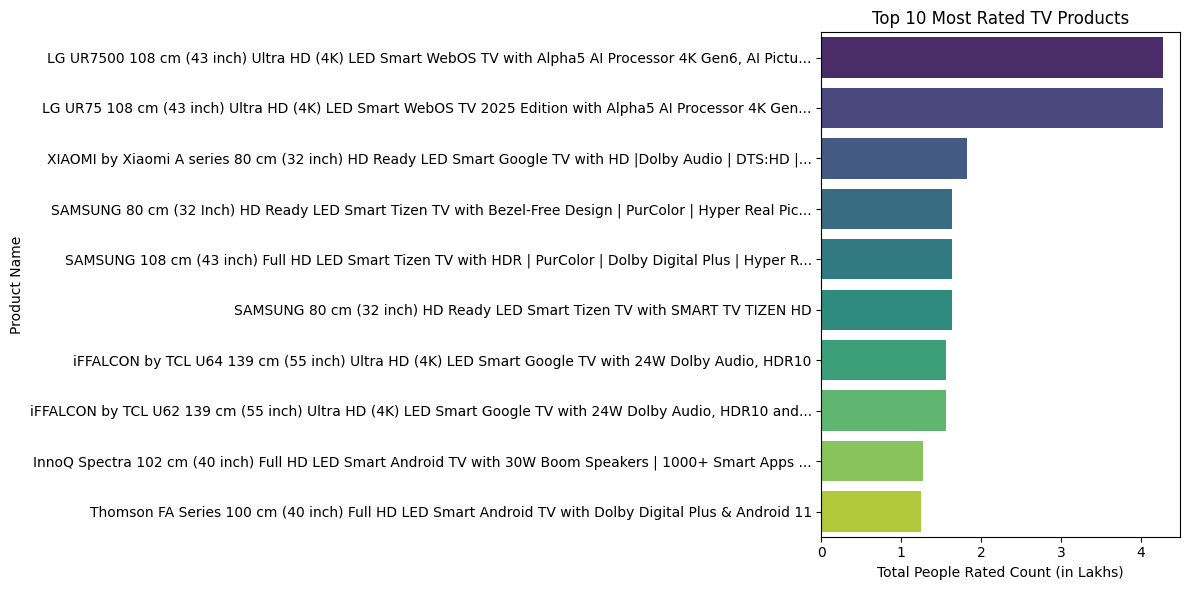

In [ ]:

import seaborn as sns
# Group by Product Name and sum the People_rated_count
most_sold_tv = df_tv.groupby('Product_name')['People_rated_count'].sum().reset_index()

# Sort by the total people rated count in descending order
most_sold_tv = most_sold_tv.sort_values(by='People_rated_count', ascending=False)

# Select the top N products for better visualization (e.g., top 10)
top_n_tv = 10
top_selling_tv = most_sold_tv.head(top_n_tv)

# Convert People_rated_count to lakhs for the plot
top_selling_tv['People_rated_count_lakhs'] = top_selling_tv['People_rated_count'] / 100000

# Create a bar plot for most sold TV product_name
plt.figure(figsize=(12, 6))
sns.barplot(x='People_rated_count_lakhs', y='Product_name', data=top_selling_tv, palette='viridis')
plt.xlabel('Total People Rated Count (in Lakhs)')
plt.ylabel('Product Name')
plt.title(f'Top {top_n_tv} Most Rated TV Products')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# **LG is most rated/bought tv brand and a clear winner**

# Creating **df_bike** csv file and analysis

In [ ]:
#Importing necessary Librarires

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import tempfile
import re

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException


def get_flipkart_data_selenium(category_url, pages=1):

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
    }

    # Selenium WebDriver set up
    options = webdriver.ChromeOptions()

    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    options.add_argument(f'user-agent={headers["User-Agent"]}')


    options.add_argument('--no-first-run')
    options.add_argument('--no-default-browser-check')



    temp_dir = tempfile.mkdtemp()
    options.add_argument(f'user-data-dir={temp_dir}')
    print(f"Using temporary user data directory: {temp_dir}")


    try:

        driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
    except Exception as e:
        print(f"Error initializing WebDriver: {e}")

        if 'temp_dir' in locals() and os.path.exists(temp_dir):

             try:
                 import shutil
                 shutil.rmtree(temp_dir)
                 print(f"Cleaned up temporary directory: {temp_dir}")
             except Exception as cleanup_e:
                 print(f"Error during cleanup of {temp_dir}: {cleanup_e}")

        return pd.DataFrame()


    Product_name=[]
    Price =[]
    Rating=[]
    People_rated_count = []
    People_reviewed_count = []

    for page in range(1, pages + 1):
        url = f"{category_url}&page={page}"
        print(f"Attempting to retrieve page: {url}")

        try:
            driver.get(url)


            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.CLASS_NAME, 'DOjaWF'))
            )


            soup = BeautifulSoup(driver.page_source, 'html.parser')

            main_container = soup.find('div', {'class': 'DOjaWF gdgoEp'})

            if main_container:

                Products = main_container.find_all("div", class_="cPHDOP col-12-12")
                if not Products:
                    print(f"No products found on page {page}.")
            else:
                Products = []
                print(f"Main container not found on page {page}.")

            for Product in Products :
                try:
                    name_element = Product.find("div",class_ ="KzDlHZ")
                    name = name_element.text.strip() if name_element else "N/A"

                    price_element = Product.find('div', {'class': 'Nx9bqj _4b5DiR'})
                    price = price_element.text.strip() if price_element else "N/A"

                    rating_element = Product.find('div', {'class': 'XQDdHH'})
                    rating = rating_element.text.strip() if rating_element else "N/A"




                    container = Product.find('span', class_='Wphh3N')
                    people_rated_count = 0
                    if container:
                       spans = container.find_all('span')
                       if spans:
                          ratings_text = spans[0].get_text()
                          try:
                              people_rated_count = int(re.search(r'([\d,]+)', ratings_text).group(1).replace(',', ''))
                          except Exception:
                              people_rated_count = 0


                    people_reviewed_count = 0
                    reviewed_element = Product.find('span', class_='hG7V+4')
                    if reviewed_element:

                       next_sibling = reviewed_element.find_next_sibling('span')
                       if next_sibling:
                          reviews_text = next_sibling.get_text()
                          try:
                              people_reviewed_count = int(re.search(r'([\d,]+)', reviews_text).group(1).replace(',', ''))
                          except Exception:
                               people_reviewed_count = 0






                    Product_name.append(name)
                    Price.append(price)
                    Rating.append(rating)

                    People_rated_count.append(people_rated_count)
                    People_reviewed_count.append(people_reviewed_count)

                except Exception as e:
                    print(f"Error processing product element on page {page}: {e}")



        except TimeoutException:
            print(f"Timeout waiting for page {page} to load. Skipping page.")
        except Exception as e:
            print(f"An error occurred while processing page {page}: {e}")



        time.sleep(7)

    driver.quit()

    # Clean up temporary  data directory
    if 'temp_dir' in locals() and os.path.exists(temp_dir):
        try:
            import shutil
            shutil.rmtree(temp_dir)
            print(f"Cleaned up temporary directory: {temp_dir}")
        except Exception as cleanup_e:
            print(f"Error during cleanup of {temp_dir}: {cleanup_e}")



    products_df = pd.DataFrame({
        'Product_name': Product_name,
        'Price': Price,
        'Rating': Rating,
        'People_rated_count': People_rated_count,
        'People_reviewed_count': People_reviewed_count

    })

    return products_df


category_url = "https://www.flipkart.com/search?q=two+wheelers&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
df_bike = get_flipkart_data_selenium(category_url, pages=20) # Use the new function name
if not df_bike.empty:
    df_bike.to_csv('flipkart_two_wheelers.csv', index=False)
    print("Data successfully scraped and saved to flipkart_two_wheelers.csv")
else:
    print("No data scraped. CSV file not created.")

Using temporary user data directory: /tmp/tmpybb7adx5
Attempting to retrieve page: https://www.flipkart.com/search?q=two+wheelers&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=1
Attempting to retrieve page: https://www.flipkart.com/search?q=two+wheelers&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=2
Attempting to retrieve page: https://www.flipkart.com/search?q=two+wheelers&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=3
Attempting to retrieve page: https://www.flipkart.com/search?q=two+wheelers&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=4
Attempting to retrieve page: https://www.flipkart.com/search?q=two+wheelers&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=5
Attempting to retrieve page: https://www.flipkart.com/search?q=two+wheelers&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=6
Attempting to re

In [ ]:
df_bike.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count
0,Ather Ather_450X_2.9 with Pro Pack Booking for...,"₹1,64,262",N/A,0,0
1,Ather Rizta S 2.9 kWh Battery Booking for Ex-S...,"₹1,07,999",4.3,692,79
2,Hero Pleasure+ (XTEC Connected) Booking for Ex...,"₹84,463",4.5,3069,276
3,Ather Rizta Z 2.9 kWh Battery with Pro Pack Bo...,"₹1,48,999",4.4,573,59
4,TVS XL100 Booking for Ex-Showroom Price,"₹60,999",4.3,59,7


In [ ]:
# add a new column category and put value "automobile"

df_bike['category'] = 'automobile'

In [ ]:
df_bike.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,category
0,Ather Ather_450X_2.9 with Pro Pack Booking for...,"₹1,64,262",N/A,0,0,automobile
1,Ather Rizta S 2.9 kWh Battery Booking for Ex-S...,"₹1,07,999",4.3,692,79,automobile
2,Hero Pleasure+ (XTEC Connected) Booking for Ex...,"₹84,463",4.5,3069,276,automobile
3,Ather Rizta Z 2.9 kWh Battery with Pro Pack Bo...,"₹1,48,999",4.4,573,59,automobile
4,TVS XL100 Booking for Ex-Showroom Price,"₹60,999",4.3,59,7,automobile


In [ ]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Product_name           482 non-null    object
 1   Price                  482 non-null    object
 2   Rating                 482 non-null    object
 3   People_rated_count     482 non-null    int64 
 4   People_reviewed_count  482 non-null    int64 
 5   category               482 non-null    object
dtypes: int64(2), object(4)
memory usage: 22.7+ KB


In [ ]:
df_bike.shape

(482, 6)

In [ ]:
# find duplicate and remove from df_bike

# Identify duplicate rows
duplicates_bike = df_bike.duplicated()

# Print the number of duplicate rows found
print(f"Number of duplicate rows found in df_bike: {duplicates_bike.sum()}")

# Remove duplicate rows
df_bike_no_duplicates = df_bike.drop_duplicates()

# Print the shape of the dataframe after removing duplicates
print(f"Shape of df_bike after removing duplicates: {df_bike_no_duplicates.shape}")

# Optionally, replace the original dataframe with the one without duplicates
df_bike = df_bike_no_duplicates

Number of duplicate rows found in df_bike: 0
Shape of df_bike after removing duplicates: (264, 6)


In [ ]:

# Ensure 'Price' is treated as string before cleaning and converting
df_bike['Price'] = df_bike['Price'].astype(str).replace('N/A', '0').str.replace('[₹,]', '', regex=True).astype(int)

# Ensure 'Rating' is treated as string before cleaning and converting
df_bike['Rating'] = df_bike['Rating'].astype(str).replace('N/A', '0').astype(float)



In [ ]:
df_bike.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,category
0,Ather Ather_450X_2.9 with Pro Pack Booking for...,164262,0.0,0,0,automobile
1,Ather Rizta S 2.9 kWh Battery Booking for Ex-S...,107999,4.3,692,79,automobile
2,Hero Pleasure+ (XTEC Connected) Booking for Ex...,84463,4.5,3069,276,automobile
3,Ather Rizta Z 2.9 kWh Battery with Pro Pack Bo...,148999,4.4,573,59,automobile
4,TVS XL100 Booking for Ex-Showroom Price,60999,4.3,59,7,automobile


In [ ]:

import altair as alt
# Sort the dataframe by People_rated_count in descending order and select the top product
top_product = df_bike.sort_values('People_rated_count', ascending=False).iloc[0]
# Create a bar chart
chart = alt.Chart(df_bike).mark_bar().encode(
    x=alt.X('Product_name', sort='-y', title='Product Name'), # Set Product_name as the x-axis and sort by People_rated_count
    y=alt.Y('People_rated_count', title='Number of People Rated') # Set People_rated_count as the y-axis
).properties(
    title='Most Sold Product Name'
).interactive() # Make the chart interactive

chart

alt.Chart(...)

# **Most sold bike are Hero Xtreme and VIDA V2 Plus but EV is dominating the market**

In [ ]:
# merge all 3 dataframe df_mobile, df_tv, df_bike into single dataframe


df_combined = pd.concat([df_mobile, df_tv, df_bike], ignore_index=True)



In [ ]:
df_combined.tail()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,Memory_Specification,category,tv_size
1219,OKAYA Faast F3 Booking for Ex-Showroom Price (...,104999,4.0,6,1,NaN,automobile,NaN
1220,Joy e-bike Wolf Eco Booking for Ex-Showroom Pr...,68354,3.3,7,1,NaN,automobile,NaN
1221,Joy e-bike Gen Next Nanu Eco Booking for Ex-Sh...,67304,4.0,11,2,NaN,automobile,NaN
1222,Joy e-bike Wolf Eco Booking for Ex-Showroom Pr...,68354,3.3,7,1,NaN,automobile,NaN
1223,Joy e-bike Gen Next Nanu Eco Booking for Ex-Sh...,67304,4.0,11,2,NaN,automobile,NaN


In [ ]:
df_combined.isnull().count()

,0
Product_name,1224
Price,1224
Rating,1224
People_rated_count,1224
People_reviewed_count,1224
Memory_Specification,1224
category,1224
tv_size,1224


In [ ]:
# remove row if in product_name column having 'N/A'

df_combined = df_combined[df_combined['Product_name'] != 'N/A']

In [ ]:
df_combined.tail(5)

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,Memory_Specification,category,tv_size
1219,OKAYA Faast F3 Booking for Ex-Showroom Price (...,104999,4.0,6,1,NaN,automobile,NaN
1220,Joy e-bike Wolf Eco Booking for Ex-Showroom Pr...,68354,3.3,7,1,NaN,automobile,NaN
1221,Joy e-bike Gen Next Nanu Eco Booking for Ex-Sh...,67304,4.0,11,2,NaN,automobile,NaN
1222,Joy e-bike Wolf Eco Booking for Ex-Showroom Pr...,68354,3.3,7,1,NaN,automobile,NaN
1223,Joy e-bike Gen Next Nanu Eco Booking for Ex-Sh...,67304,4.0,11,2,NaN,automobile,NaN


In [ ]:
# raplace 'NaN' with 0 as integer in all column

for col in df_combined.columns:
    if df_combined[col].dtype == 'float64':
        df_combined[col] = df_combined[col].fillna(0).astype(int)
    elif df_combined[col].dtype == 'object':
        df_combined[col] = df_combined[col].replace('NaN', '0')


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1219 entries, 0 to 1223
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Product_name           1219 non-null   object
 1   Price                  1219 non-null   int64 
 2   Rating                 1219 non-null   int64 
 3   People_rated_count     1219 non-null   int64 
 4   People_reviewed_count  1219 non-null   int64 
 5   Memory_Specification   1219 non-null   int64 
 6   category               1219 non-null   object
 7   tv_size                1219 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 85.7+ KB


In [ ]:
df_combined.tail()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,Memory_Specification,category,tv_size
1219,OKAYA Faast F3 Booking for Ex-Showroom Price (...,104999,4,6,1,0,automobile,0
1220,Joy e-bike Wolf Eco Booking for Ex-Showroom Pr...,68354,3,7,1,0,automobile,0
1221,Joy e-bike Gen Next Nanu Eco Booking for Ex-Sh...,67304,4,11,2,0,automobile,0
1222,Joy e-bike Wolf Eco Booking for Ex-Showroom Pr...,68354,3,7,1,0,automobile,0
1223,Joy e-bike Gen Next Nanu Eco Booking for Ex-Sh...,67304,4,11,2,0,automobile,0


In [ ]:
df_combined.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,Memory_Specification,category,tv_size
0,"Motorola G85 5G (Cobalt Blue, 128 GB)",15999,4,185557,9717,128,mobile_phones,0
1,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4,169648,6066,128,mobile_phones,0
2,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4,169648,6066,128,mobile_phones,0
3,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4,169648,6066,128,mobile_phones,0
4,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,15999,4,20194,895,256,mobile_phones,0


In [ ]:
df_combined.shape

(1219, 8)

In [ ]:
df_combined.head()

,Product_name,Price,Rating,People_rated_count,People_reviewed_count,Memory_Specification,category,tv_size
0,"Motorola G85 5G (Cobalt Blue, 128 GB)",15999,4,185557,9717,128,mobile_phones,0
1,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4,169648,6066,128,mobile_phones,0
2,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4,169648,6066,128,mobile_phones,0
3,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,12999,4,169648,6066,128,mobile_phones,0
4,OPPO K12x 5G with 45W SUPERVOOC Charger In-The...,15999,4,20194,895,256,mobile_phones,0


In [ ]:
df_combined.shape

(1219, 8)

In [ ]:
from google.colab import files

# Save the combined dataframe to a CSV file before downloading
df_combined.to_csv('df_combined.csv', index=False)

files.download('df_combined.csv')
print("df_combined.csv has been downloaded.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

df_combined.csv has been downloaded.


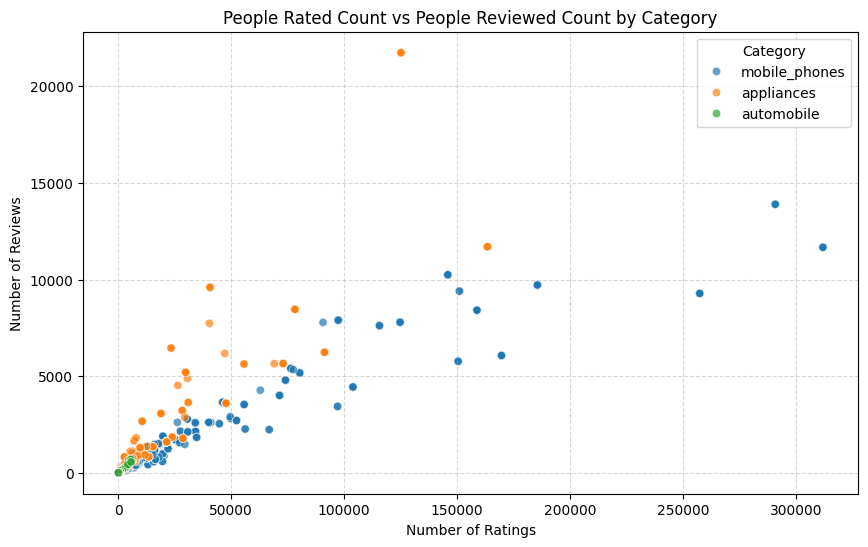

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('df_combined.csv')

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='People_rated_count',
    y='People_reviewed_count',
    hue='category',
    alpha=0.7
)
plt.title('People Rated Count vs People Reviewed Count by Category')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Reviews')
plt.legend(title='Category')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# In above Plot,
1. Products that are frequently rated are also frequently reviewed, suggesting high customer engagement and interest.
2. **Business Idea:** Focus on encouraging more reviews.
3. Some products may have a high number of ratings but disproportionately low reviews.

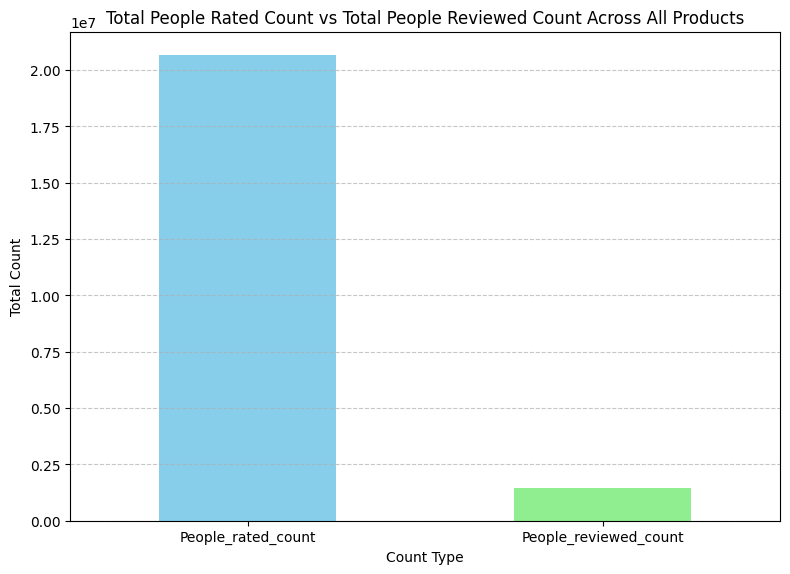

In [ ]:
# Plot People_rated_count and People_reviewed_count

# Calculate the sum of People_rated_count and People_reviewed_count
total_counts = df_combined[['People_rated_count', 'People_reviewed_count']].sum()

# Create a bar plot
plt.figure(figsize=(8, 6))
total_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Total People Rated Count vs Total People Reviewed Count Across All Products')
plt.xlabel('Count Type')
plt.ylabel('Total Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# In above Plot:
1. **For businesses**, this highlights the importance of encouraging reviews, as reviews provide more detailed feedback and can influence purchase decisions more strongly than just ratings.

# Data Overview and cleaning:
The dataset contains 1219 product listings. After initial inspection,the dataset includes the following columns: Product_name, Price, Rating, People_rated_count, People_reviewed_count, Memory_Specification, category, and tv_size. A new column named 'category' has been added for further analysis.

# Summary Statistics and Distributions
**Price:**
1. Prices (after removing one entry with 0) range from ₹200(mobile) to ₹192,380.
2.The mean price is approximately ₹55,934, with a median of ₹27,999, indicating a right-skewed distribution (a few high-priced items pull the mean up).
3. The interquartile range (25th to 75th percentile) is ₹13,999 to ₹97,598.

**Rating:**
1. Ratings range from 0 to 5. The mean rating is 3.73.
2. A significant number of products have a rating of 4.

**Price Ranges by Category:**
 1. Prices vary significantly across categories. 'Automobile' and 'appliances' appear to have a wider range and higher median prices compared to 'mobile_phones', though all categories show a wide spread. **Data Imbalance** is there.

 **Memory Specification:**
 1. This attribute is most relevant for mobile_phones. Common memory specifications (likely in GB) are 128GB (most frequent), 256GB, and 64GB.

# Anomalies, Inconsistencies, and Quality Gaps

1. **Rating = 0**: 85 products  have a rating of 0. This might mean they are unrated or genuinely have zero stars.
2. **Price Skewness:** The product catalog is dominated by items in the lower to mid-price range, but a few high-value items (luxury electronics, high-end appliances, or vehicles) significantly pull up the average price.
3. **Category Uniformity:** All products in each category have similar ratings (mostly 4), which may suggest either a bias in data collection or a lack of rating diversity.
4. **BAJAJ Pulsar NS 400z:** ₹192,328 (highest price, 3x higher than most automobiles)
5. Some **basic phones (hmd 105)** have unrealistic rated relative despite their price point
6. **Motorola g45 5G (Brilliant Blue, 128 GB):** Listed at both ₹11,999  and ₹10,999  with identical specifications. So is **vivo T4x 5G (Pronto Purple, 128 GB), REDMI 13 5G (Orchid Pink, 128 GB)**
7. **Giftsland Electric Scooter Board:** ₹270 (99.8% lower than other automobiles).

# Insights and Hypotheses
1. **Mobile Phone Market Trends:** The prevalence of 128GB and 256GB memory specifications in mobile phones aligns with current market trends.
2. **TV Market Features:** People prefer "Smart TV", "4K", "LED", "QLED", and common screen sizes(32 inch) reflect typical offerings in the television market.
3. **Automobile Listings Focus:** The 'automobile' category seems heavily focused on electric scooters (e.g., Ather, VIDA) and motorcycles (e.g., Hero,  TVS Raider, BAJAJ PULSAR).